In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG
from db import Result
import papermill as pm
import os
import seaborn
import pandas
import matplotlib.pyplot as plt
from collections import defaultdict 
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.calibration import calibration_curve
from evaluate import calculate_confusion_matrix_stats_predictions, calculate_roc_curve, roc_auc_score
from scipy.stats import binom_test, fisher_exact, chi2_contingency
from tabulate import tabulate
from calculate_features import all_features
from config import config
from data import data, load_from_pickle_source

plt.rcParams['svg.fonttype'] = 'none'

Using TensorFlow backend.
/home/intrepidlemon/.local/share/virtualenvs/renal-mri-fxqFirq4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/renal-mri-fxqFirq4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/renal-mri-fxqFirq4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)

In [2]:
# Parameters
MODALITY = "{'eff7e2af-4da0-41c4-b3a8-8e7140093544': 't2', 'e9d327c6-64f2-48e5-a666-fa0ce7eb9dc6': 't1', 'f5809fd4-ba72-4ea6-929a-44a42ba8c6fe': 'features'}"


In [3]:
SKIP = True
MODALITY = eval(MODALITY)
UUIDS = list(MODALITY.keys())

SELECTIONS = dict()

TSNE_PERPLEXITY = defaultdict(lambda: 10)

In [4]:
import math
def adjusted_wald(p, n, z=1.96):
    p_adj = (n * p + (z**2)/2)/(n+z**2)
    n_adj = n + z**2
    span = z * math.sqrt(p_adj*(1-p_adj)/n_adj)
    return max(0, p_adj - span), min(p_adj + span, 1.0)

In [5]:
def execute_notebook(uuid, selections=None, tsne_perplexity=5, input_form="none", description=""): 
    name = "evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid)
    if not os.path.exists(name): 
        pm.execute_notebook(
            "evaluate-specific-model.ipynb",
            "evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid),
            parameters = dict(
                UUID=uuid,
                SELECTIONS=repr(selections),
                TSNE_PERPLEXITY=tsne_perplexity,
            ),
    )
    return name

In [44]:
completed_notebooks = list()
modality_by_notebook = dict()

In [45]:
for uuid in UUIDS: 
    result = Result.query.filter(Result.uuid == uuid).first()
    name = execute_notebook(uuid, SELECTIONS.get(uuid), TSNE_PERPLEXITY.get(uuid, 10), result.input_form, result.description)
    completed_notebooks.append(name)
    modality_by_notebook[name] = MODALITY[uuid]

eff7e2af-4da0-41c4-b3a8-8e7140093544
done
e9d327c6-64f2-48e5-a666-fa0ce7eb9dc6
done
f5809fd4-ba72-4ea6-929a-44a42ba8c6fe
done


In [47]:
if not SKIP: 
    pm.execute_notebook(
        "evaluate-ensemble.ipynb",
        "evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)),
        parameters = dict(
            MODELS=UUIDS,
            SCORE="accuracy",
        ),
    )
completed_notebooks.append("evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)))

In [48]:
modality_by_notebook["evaluate-ensemble-{}.ipynb".format("-".join(UUIDS))] = "ensemble"

In [49]:
def get_notebook_output(notebook, name): 
    return notebook.dataframe[notebook.dataframe.name==name].value.tolist()[0]

In [50]:
train = dict()
validation = dict()
test = dict()
test_1 = dict()
test_2 = dict()
for notebook in completed_notebooks: 
    nb = pm.read_notebook(notebook)
    train["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "train_labels")
    train["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "train_predictions")
    train["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "train_probabilities")
    validation["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "validation_labels")
    validation["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "validation_predictions")
    validation["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "validation_probabilities")
    test["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test_labels")
    test["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test_predictions")
    test["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test_probabilities")
    test_1["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-1_labels")
    test_1["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-1_predictions")
    test_1["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-1_probabilities")
    test_2["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-2_labels")
    test_2["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-2_predictions")
    test_2["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-2_probabilities")    

In [13]:
train.keys()

dict_keys(['t2-labels', 't2-predictions', 't2-probabilities', 't1-labels', 't1-predictions', 't1-probabilities', 'features-labels', 'features-predictions', 'features-probabilities', 'ensemble-labels', 'ensemble-predictions', 'ensemble-probabilities'])

In [14]:
completed_notebooks

['evaluate-pheno-split-t2-eff7e2af-4da0-41c4-b3a8-8e7140093544.ipynb',
 'evaluate-pheno-split-t1-e9d327c6-64f2-48e5-a666-fa0ce7eb9dc6.ipynb',
 'evaluate-pheno-split-features-f5809fd4-ba72-4ea6-929a-44a42ba8c6fe.ipynb',
 'evaluate-ensemble-eff7e2af-4da0-41c4-b3a8-8e7140093544-e9d327c6-64f2-48e5-a666-fa0ce7eb9dc6-f5809fd4-ba72-4ea6-929a-44a42ba8c6fe.ipynb']

In [ ]:
import uuid
result = Result.query.filter(Result.uuid == UUIDS[0]).first()
train_set, validation_set, test_set = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

In [56]:
MODALITIES = [
    "features",     
    "t1",    
    "t2",
    "ensemble",     
#    "t1-sensitive",    
#    "t2-specific",
]

MODALITY_KEY = {
    "features": "Clinical",     
    "t1": "T1C", 
    "t2": "T2WI", 
    "t1-sensitive": "T1C Sensitive", 
    "t2-sensitive": "T2WI Sensitive",     
    "t1-specific": "T1C Specific", 
    "t2-specific": "T2WI Specific",         
    "ensemble": "Ensemble", 
}

def get_pr_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        acc = accuracy_score(labels, predictions)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})           
    return results, pr_auc, []
        


def get_roc_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})        
    return results, roc_auc, []

def get_reliability_data_for_modality(dataset, comparison_models=[], n_bins=10): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        positives, mean_predicted_value = calibration_curve(labels, probabilities, n_bins=n_bins)
        points.append({
            "modality": "{}".format(MODALITY_KEY[modality]),
            "positives": positives,
            "MPV": mean_predicted_value,
        })
        for p, m in zip(positives, mean_predicted_value): 
            results.append({ "positives": p, "mpv": m, "modality": "{}".format(MODALITY_KEY[modality])})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        positives, mean_predicted_value = calibration_curve(labels, probabilities, n_bins=n_bins)
        points.append({
            "modality": "{}".format(MODALITY_KEY[modality]),
            "positives": positives,
            "MPV": mean_predicted_value,
        })
        for p, m in zip(positives, mean_predicted_value): 
            results.append({ "positives": p, "mpv": m, "modality": "{}".format(MODALITY_KEY[modality])})        
    return results



def get_statistics(dataset, experts=[], comparison_models=[]): 
    results = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats_predictions(labels, predictions), 
            "Modality": [modality.capitalize(), modality.capitalize()], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])], 
        } 
        # remove more that are not relevant to imbalanced datasets
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]    
        del d["AM"]
        del d["GM"]
        del d["FPR"]
        del d["FNR"]
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]
        results.append(pandas.DataFrame(d).iloc[[1]])
    for i, expert in enumerate(experts): 
        labels = dataset["ensemble-labels"]
        predictions = expert
        f1 = f1_score(labels, predictions)        
        d = {
            "F1 Score": [f1, f1],            
            **calculate_confusion_matrix_stats_predictions(labels, predictions),             
            "Modality": ["Expert {}".format(i + 1), "Expert {}".format(i + 1)], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        }
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]               
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]        
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    for probabilities in comparison_models: 
        labels = dataset["ensemble-labels"]
        predictions = [p > 0.5 for p in probabilities]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats_predictions(labels, predictions), 
            "Modality": ["Radiomics", "Radiomics"], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        } 
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]         
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        results.append(pandas.DataFrame(d).iloc[[1]])

    return pandas.concat(results, axis=0, sort=False).set_index("Modality")

def get_experts_for_names(features, names, experts=[], transform=int, default=0): 
    result = list()
    for e in experts: 
        expert_results = list()
        for n in names: 
            f = features.get(n, None)
            if f is None: 
                # print("error, cannot find {}".format(n))
                expert_results.append(default)
                continue
            r = f.get(e, default)
            if r == "": 
                r = 0
            r = transform(r)
            expert_results.append(r)
        result.append(expert_results)
    return result

In [18]:
expert_features = all_features(files = [config.EXPERTS])
comparison_model_features = all_features(files=["features/comparison-models.csv"])
df = get_statistics(train, get_experts_for_names(expert_features, train_set.names), get_experts_for_names(comparison_model_features, train_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print("##### Train")
df


df = get_statistics(validation, get_experts_for_names(expert_features, validation_set.names), get_experts_for_names(comparison_model_features, validation_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print("##### Validation")
df


df = get_statistics(test, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
test_statistics = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print("##### Test")
print()
df



df = get_statistics(test_1)
test_1_statistics = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print("##### Test 1")
df


df = get_statistics(test_2)
test_2_statistics = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print("##### Test 2")
df

df = get_statistics(test, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
test_statistics = df
df = get_statistics(test, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["zero"], transform=float))
test_statistics_zero = df


##### Train

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |     FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     |
|:-----------|-----------:|----------:|---------:|------:|------:|--------:|:-----------------|:-----------------|:-----------------|
| Clinical   |     0.757  |     0.730 |    0.724 | 0.673 | 0.724 | 0.327   | 0.69 (0.65-0.72) | 0.87 (0.83-0.89) | 0.46 (0.41-0.51) |
| T1         |     0.995  |     0.999 |    0.999 | 0.993 | 0.994 | 0.00651 | 0.99 (0.99-1.00) | 1.00 (0.98-1.00) | 0.99 (0.97-1.00) |
| T2         |     0.949  |     0.987 |    0.989 | 0.926 | 0.964 | 0.0744  | 0.94 (0.92-0.96) | 0.97 (0.95-0.99) | 0.90 (0.86-0.93) |
| Ensemble   |     0.969  |     0.993 |    0.994 | 0.959 | 0.971 | 0.0405  | 0.96 (0.95-0.98) | 0.98 (0.96-0.99) | 0.95 (0.92-0.97) |
| Radiomics  |     0.0130 |     0.503 |    0.783 | 1.00  | 0.438 | 0.00    | 0.44 (0.41-0.47) | 0.01 (0.00-0.02) | 1.00 (0.99-1.00) |

##### Validation

| Modality   |   F1 Score |  

/home/intrepidlemon/renal-mri/evaluate.py:130: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
/home/intrepidlemon/renal-mri/evaluate.py:132: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN/(TN+FN)
/home/intrepidlemon/renal-mri/evaluate.py:138: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)
/home/intrepidlemon/renal-mri/evaluate.py:130: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
/home/intrepidlemon/renal-mri/evaluate.py:132: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN/(TN+FN)
/home/intrepidlemon/renal-mri/evaluate.py:138: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


In [90]:
def plot_multiple_reliability_curve(dataset, comparison_models=[], n_bins=10):
    results = get_reliability_data_for_modality(dataset, comparison_models, n_bins)
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="mpv",
        y="positives",
        style="modality",
        hue="modality", 
        ax=ax,
        err_style=None,
        dashes=[(1, 3), (1, 1), (3, 1), ''], 
    )
    ax.plot([-2, 2], [-2, 2], linewidth=0.5, linestyle='-', color="grey")
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

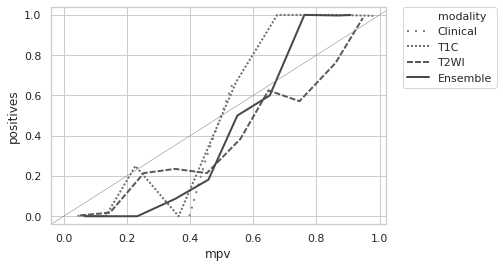

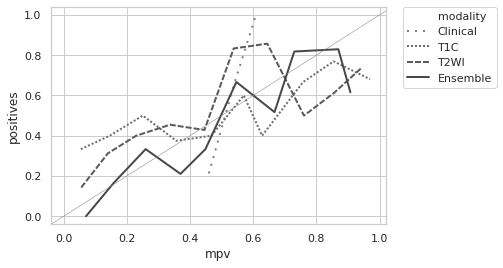

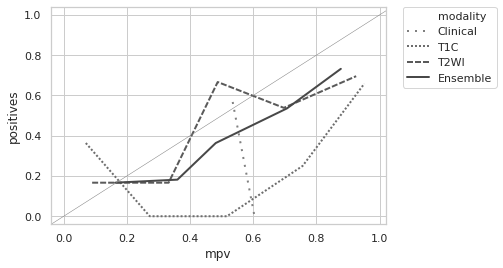

In [91]:
fig = plot_multiple_reliability_curve(train)
fig = plot_multiple_reliability_curve(validation) 
fig = plot_multiple_reliability_curve(test, n_bins=5) 

In [92]:
def plot_multiple_precision_recall(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_pr_data_for_modality(dataset, comparison_models)        
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)
            points.append({
                "precision": stats["PPV"][1],
                "recall": stats["TPR"][1],                
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="recall",
        y="precision",
        hue="modality",
        style="modality",
        ax=ax, 
        err_style=None,
        dashes=[(1, 3), (1, 1), (3, 1), ''], 
    )
    if points: 
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="recall",
            y="precision",
            hue="experts",
            style="experts",                        
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },            
            ax=ax,
        )
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig


features 816 816 816
t1 816 816 816
t2 816 816 816
ensemble 816 816 816


/home/intrepidlemon/.local/share/virtualenvs/renal-mri-fxqFirq4/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


features 234 234 234
t1 234 234 234
t2 234 234 234
ensemble 234 234 234
features 112 112 112
t1 112 112 112
t2 112 112 112
ensemble 112 112 112
features 112 112 112
t1 112 112 112
t2 112 112 112
ensemble 112 112 112
features 112 112 112
t1 112 112 112
t2 112 112 112
ensemble 112 112 112


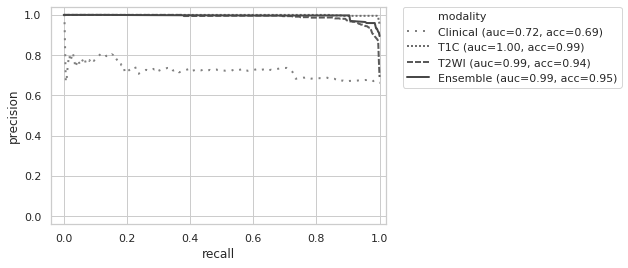

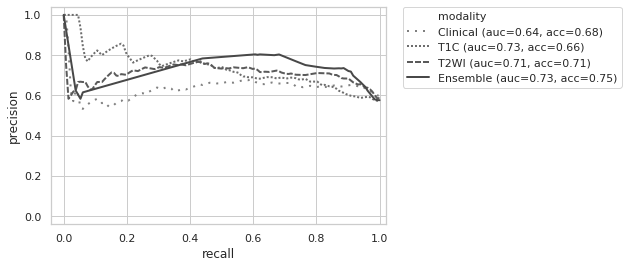

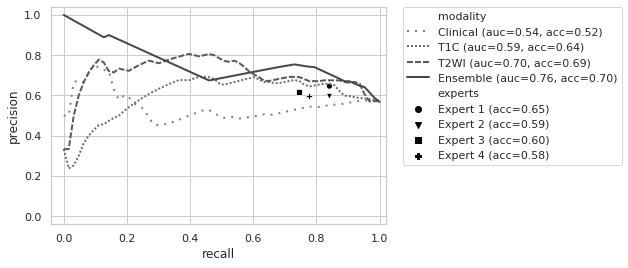

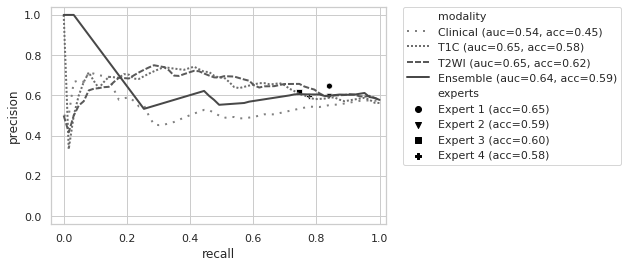

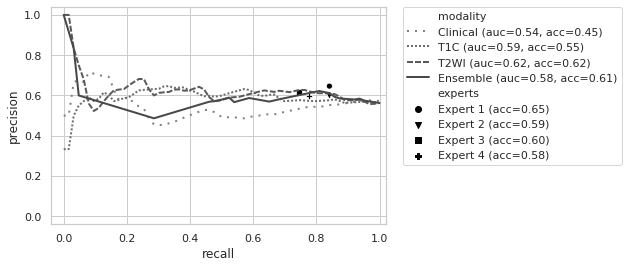

In [93]:
fig = plot_multiple_precision_recall(train, experts=get_experts_for_names(expert_features, train_set.names))
fig = plot_multiple_precision_recall(validation, experts=get_experts_for_names(expert_features, validation_set.names))
fig = plot_multiple_precision_recall(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))
fig = plot_multiple_precision_recall(test_1, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))
fig = plot_multiple_precision_recall(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))


In [94]:

def plot_multiple_roc_curve(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_roc_data_for_modality(dataset, comparison_models)
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)            
            points.append({
                "fpr": stats["FPR"][1],
                "tpr": stats["TPR"][1],
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc),                 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="fpr",
        y="tpr",
        style="modality",
        hue="modality", 
        ax=ax,
        err_style=None,
        dashes=[(1, 3), (1, 1), (3, 1), ''], 
    )
    if points:     
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="fpr",
            y="tpr",
            hue="experts",
            style="experts",            
            ax=ax,
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },
        )
    ax.plot([-2, 2], [-2, 2], linewidth=0.5, linestyle='-', color="grey")
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

/home/intrepidlemon/.local/share/virtualenvs/renal-mri-fxqFirq4/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/intrepidlemon/.local/share/virtualenvs/renal-mri-fxqFirq4/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/intrepidlemon/.local/share/virtualenvs/renal-mri-fxqFirq4/lib/python3.6/

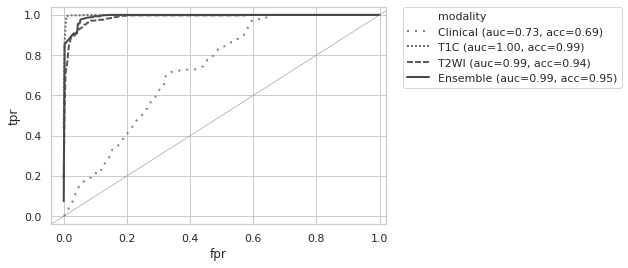

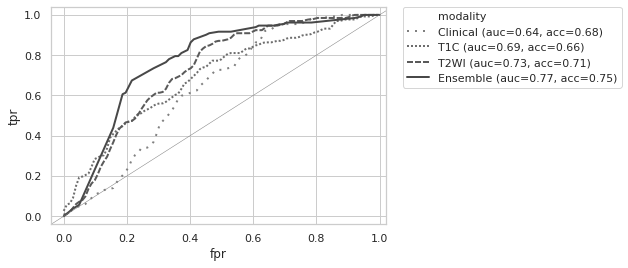

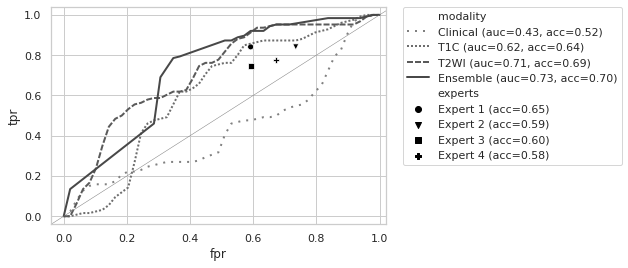

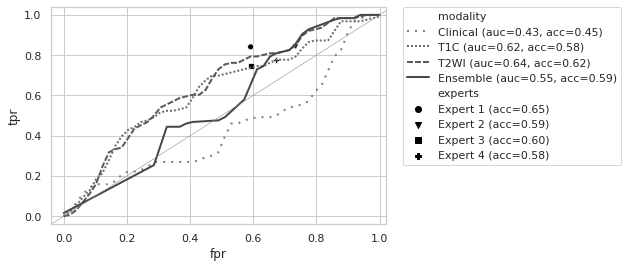

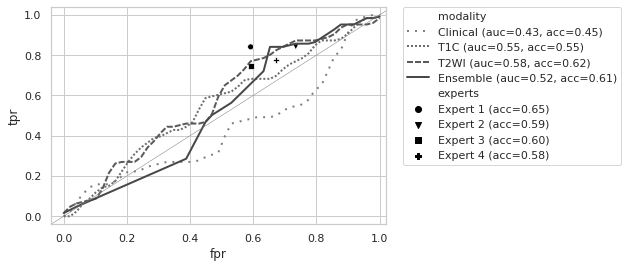

In [95]:
fig = plot_multiple_roc_curve(train, experts=get_experts_for_names(expert_features, train_set.names))
fig = plot_multiple_roc_curve(validation, experts=get_experts_for_names(expert_features, validation_set.names))
fig = plot_multiple_roc_curve(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))
fig = plot_multiple_roc_curve(test_1, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))
fig = plot_multiple_roc_curve(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))

In [39]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')